In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")


In [14]:
# Loading the data
# ! pip install openpyxl xlrd
df = pd.read_excel('mahudhirio(1).xls', engine='xlrd')
df

*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'


,Department,Name,No.,Date/Time,Status,ID Number
0,EASTC,Doris Sanga,2,05/02/2022 11:39,C/In,NaN
1,EASTC,Doris Sanga,2,05/05/2022 08:48,C/In,NaN
2,EASTC,Doris Sanga,2,05/05/2022 16:03,C/Out,NaN
3,EASTC,Doris Sanga,2,05/06/2022 08:53,C/In,NaN
4,EASTC,Doris Sanga,2,05/06/2022 16:26,C/Out,NaN
...,...,...,...,...,...,...
1689,JUMA,Ivod Sin,1,05/26/2022 09:07,C/In,NaN
1690,JUMA,Ivod Sin,1,05/26/2022 17:12,C/Out,NaN
1691,JUMA,Ivod Sin,1,05/27/2022 08:11,C/In,NaN
1692,JUMA,Ivod Sin,1,05/27/2022 17:50,C/Out,NaN


## Data Preprocessing

In [15]:
# Convert Date/Time to datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df['Date'] = df['Date/Time'].dt.date
df['Time'] = df['Date/Time'].dt.time
df['Day'] = df['Date/Time'].dt.day_name()


In [16]:
df.head()

,Department,Name,No.,Date/Time,Status,ID Number,Date,Time,Day
0,EASTC,Doris Sanga,2,2022-05-02 11:39:00,C/In,NaN,2022-05-02,11:39:00,Monday
1,EASTC,Doris Sanga,2,2022-05-05 08:48:00,C/In,NaN,2022-05-05,08:48:00,Thursday
2,EASTC,Doris Sanga,2,2022-05-05 16:03:00,C/Out,NaN,2022-05-05,16:03:00,Thursday
3,EASTC,Doris Sanga,2,2022-05-06 08:53:00,C/In,NaN,2022-05-06,08:53:00,Friday
4,EASTC,Doris Sanga,2,2022-05-06 16:26:00,C/Out,NaN,2022-05-06,16:26:00,Friday


## Sort and filter data

In [19]:
# Sort data by Name and Date/Time
df = df.sort_values(by=['Name', 'Date/Time'])

# Filter C/In and C/Out for each day
checkins = df[df['Status'] == 'C/In']
checkouts = df[df['Status'] == 'C/Out']



,Department,Name,No.,Date/Time,Status,ID Number,Date,Time,Day
1473,EASTC,Ali H A Khelef,91,2022-05-02 13:28:00,C/In,NaN,2022-05-02,13:28:00,Monday
1474,EASTC,Ali H A Khelef,91,2022-05-09 07:40:00,C/In,NaN,2022-05-09,07:40:00,Monday
1476,EASTC,Ali H A Khelef,91,2022-05-10 07:07:00,C/In,NaN,2022-05-10,07:07:00,Tuesday
1478,EASTC,Ali H A Khelef,91,2022-05-11 07:10:00,C/In,NaN,2022-05-11,07:10:00,Wednesday
1480,EASTC,Ali H A Khelef,91,2022-05-12 07:07:00,C/In,NaN,2022-05-12,07:07:00,Thursday
...,...,...,...,...,...,...,...,...,...
415,EASTC,victor Maneno Mwankwasya,17,2022-05-25 08:35:00,C/In,NaN,2022-05-25,08:35:00,Wednesday
417,EASTC,victor Maneno Mwankwasya,17,2022-05-26 08:43:00,C/In,NaN,2022-05-26,08:43:00,Thursday
419,EASTC,victor Maneno Mwankwasya,17,2022-05-27 07:17:00,C/In,NaN,2022-05-27,07:17:00,Friday
421,EASTC,victor Maneno Mwankwasya,17,2022-05-30 08:54:00,C/In,NaN,2022-05-30,08:54:00,Monday


## Feature engineering


In [20]:
# Merge C/In and C/Out data to calculate time spent each day
daily_data = pd.merge(checkins, checkouts, on=['Name', 'Date'], suffixes=('_in', '_out'))
daily_data['Duration'] = (daily_data['Date/Time_out'] - daily_data['Date/Time_in']).dt.total_seconds() / 3600  # hours


In [23]:
# Calculate Duration Between C/In and C/Out
daily_data.head()

,Department_in,Name,No._in,Date/Time_in,Status_in,ID Number_in,Date,Time_in,Day_in,Department_out,No._out,Date/Time_out,Status_out,ID Number_out,Time_out,Day_out,Duration
0,EASTC,Ali H A Khelef,91,2022-05-09 07:40:00,C/In,NaN,2022-05-09,07:40:00,Monday,EASTC,91,2022-05-09 20:16:00,C/Out,NaN,20:16:00,Monday,12.600000
1,EASTC,Ali H A Khelef,91,2022-05-10 07:07:00,C/In,NaN,2022-05-10,07:07:00,Tuesday,EASTC,91,2022-05-10 16:33:00,C/Out,NaN,16:33:00,Tuesday,9.433333
2,EASTC,Ali H A Khelef,91,2022-05-11 07:10:00,C/In,NaN,2022-05-11,07:10:00,Wednesday,EASTC,91,2022-05-11 16:08:00,C/Out,NaN,16:08:00,Wednesday,8.966667
3,EASTC,Ali H A Khelef,91,2022-05-12 07:07:00,C/In,NaN,2022-05-12,07:07:00,Thursday,EASTC,91,2022-05-12 21:19:00,C/Out,NaN,21:19:00,Thursday,14.200000
4,EASTC,Ali H A Khelef,91,2022-05-13 06:53:00,C/In,NaN,2022-05-13,06:53:00,Friday,EASTC,91,2022-05-13 16:15:00,C/Out,NaN,16:15:00,Friday,9.366667


## Calculate Weekly Hours


In [26]:
# Convert Date to datetime and extract the week number
daily_data['Week'] = pd.to_datetime(daily_data['Date/Time_in']).dt.isocalendar().week
weekly_hours = daily_data.groupby(['Name', 'Week'])['Duration'].sum().reset_index()
weekly_hours.rename(columns={'Duration': 'Total_Hours'}, inplace=True)
weekly_hours

,Name,Week,Total_Hours
0,Ali H A Khelef,19,54.566667
1,Ali H A Khelef,20,7.366667
2,Ali Swalehe Mapui,18,8.216667
3,Ali Swalehe Mapui,19,16.833333
4,Ali Swalehe Mapui,20,18.366667
...,...,...,...
215,victor Maneno Mwankwasya,18,24.300000
216,victor Maneno Mwankwasya,19,45.150000
217,victor Maneno Mwankwasya,20,31.550000
218,victor Maneno Mwankwasya,21,35.666667


## Exploratory data analysis

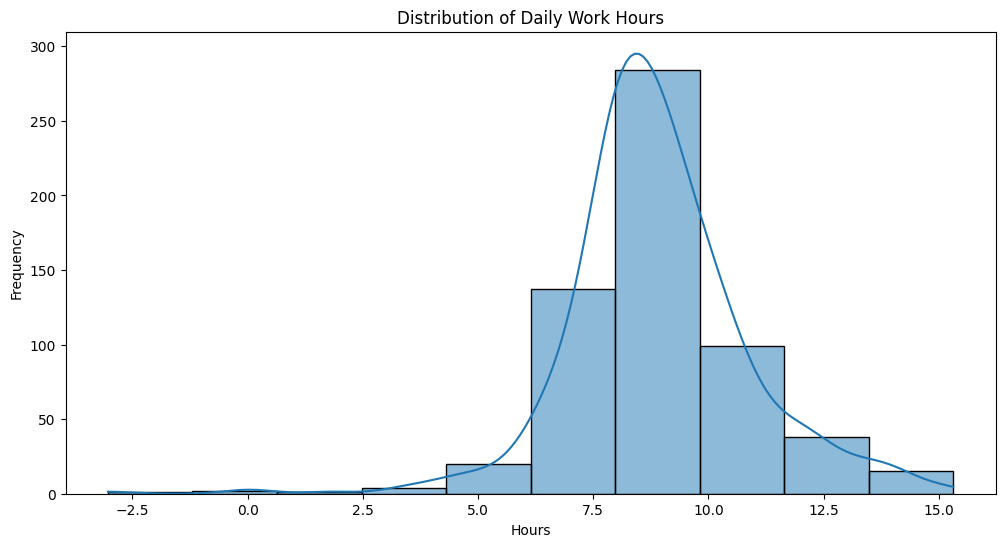

In [28]:
plt.figure(figsize=(12, 6))
sns.histplot(daily_data['Duration'], bins=10, kde=True)
plt.title('Distribution of Daily Work Hours')
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.show()


## Heatmap for Daily Attendance


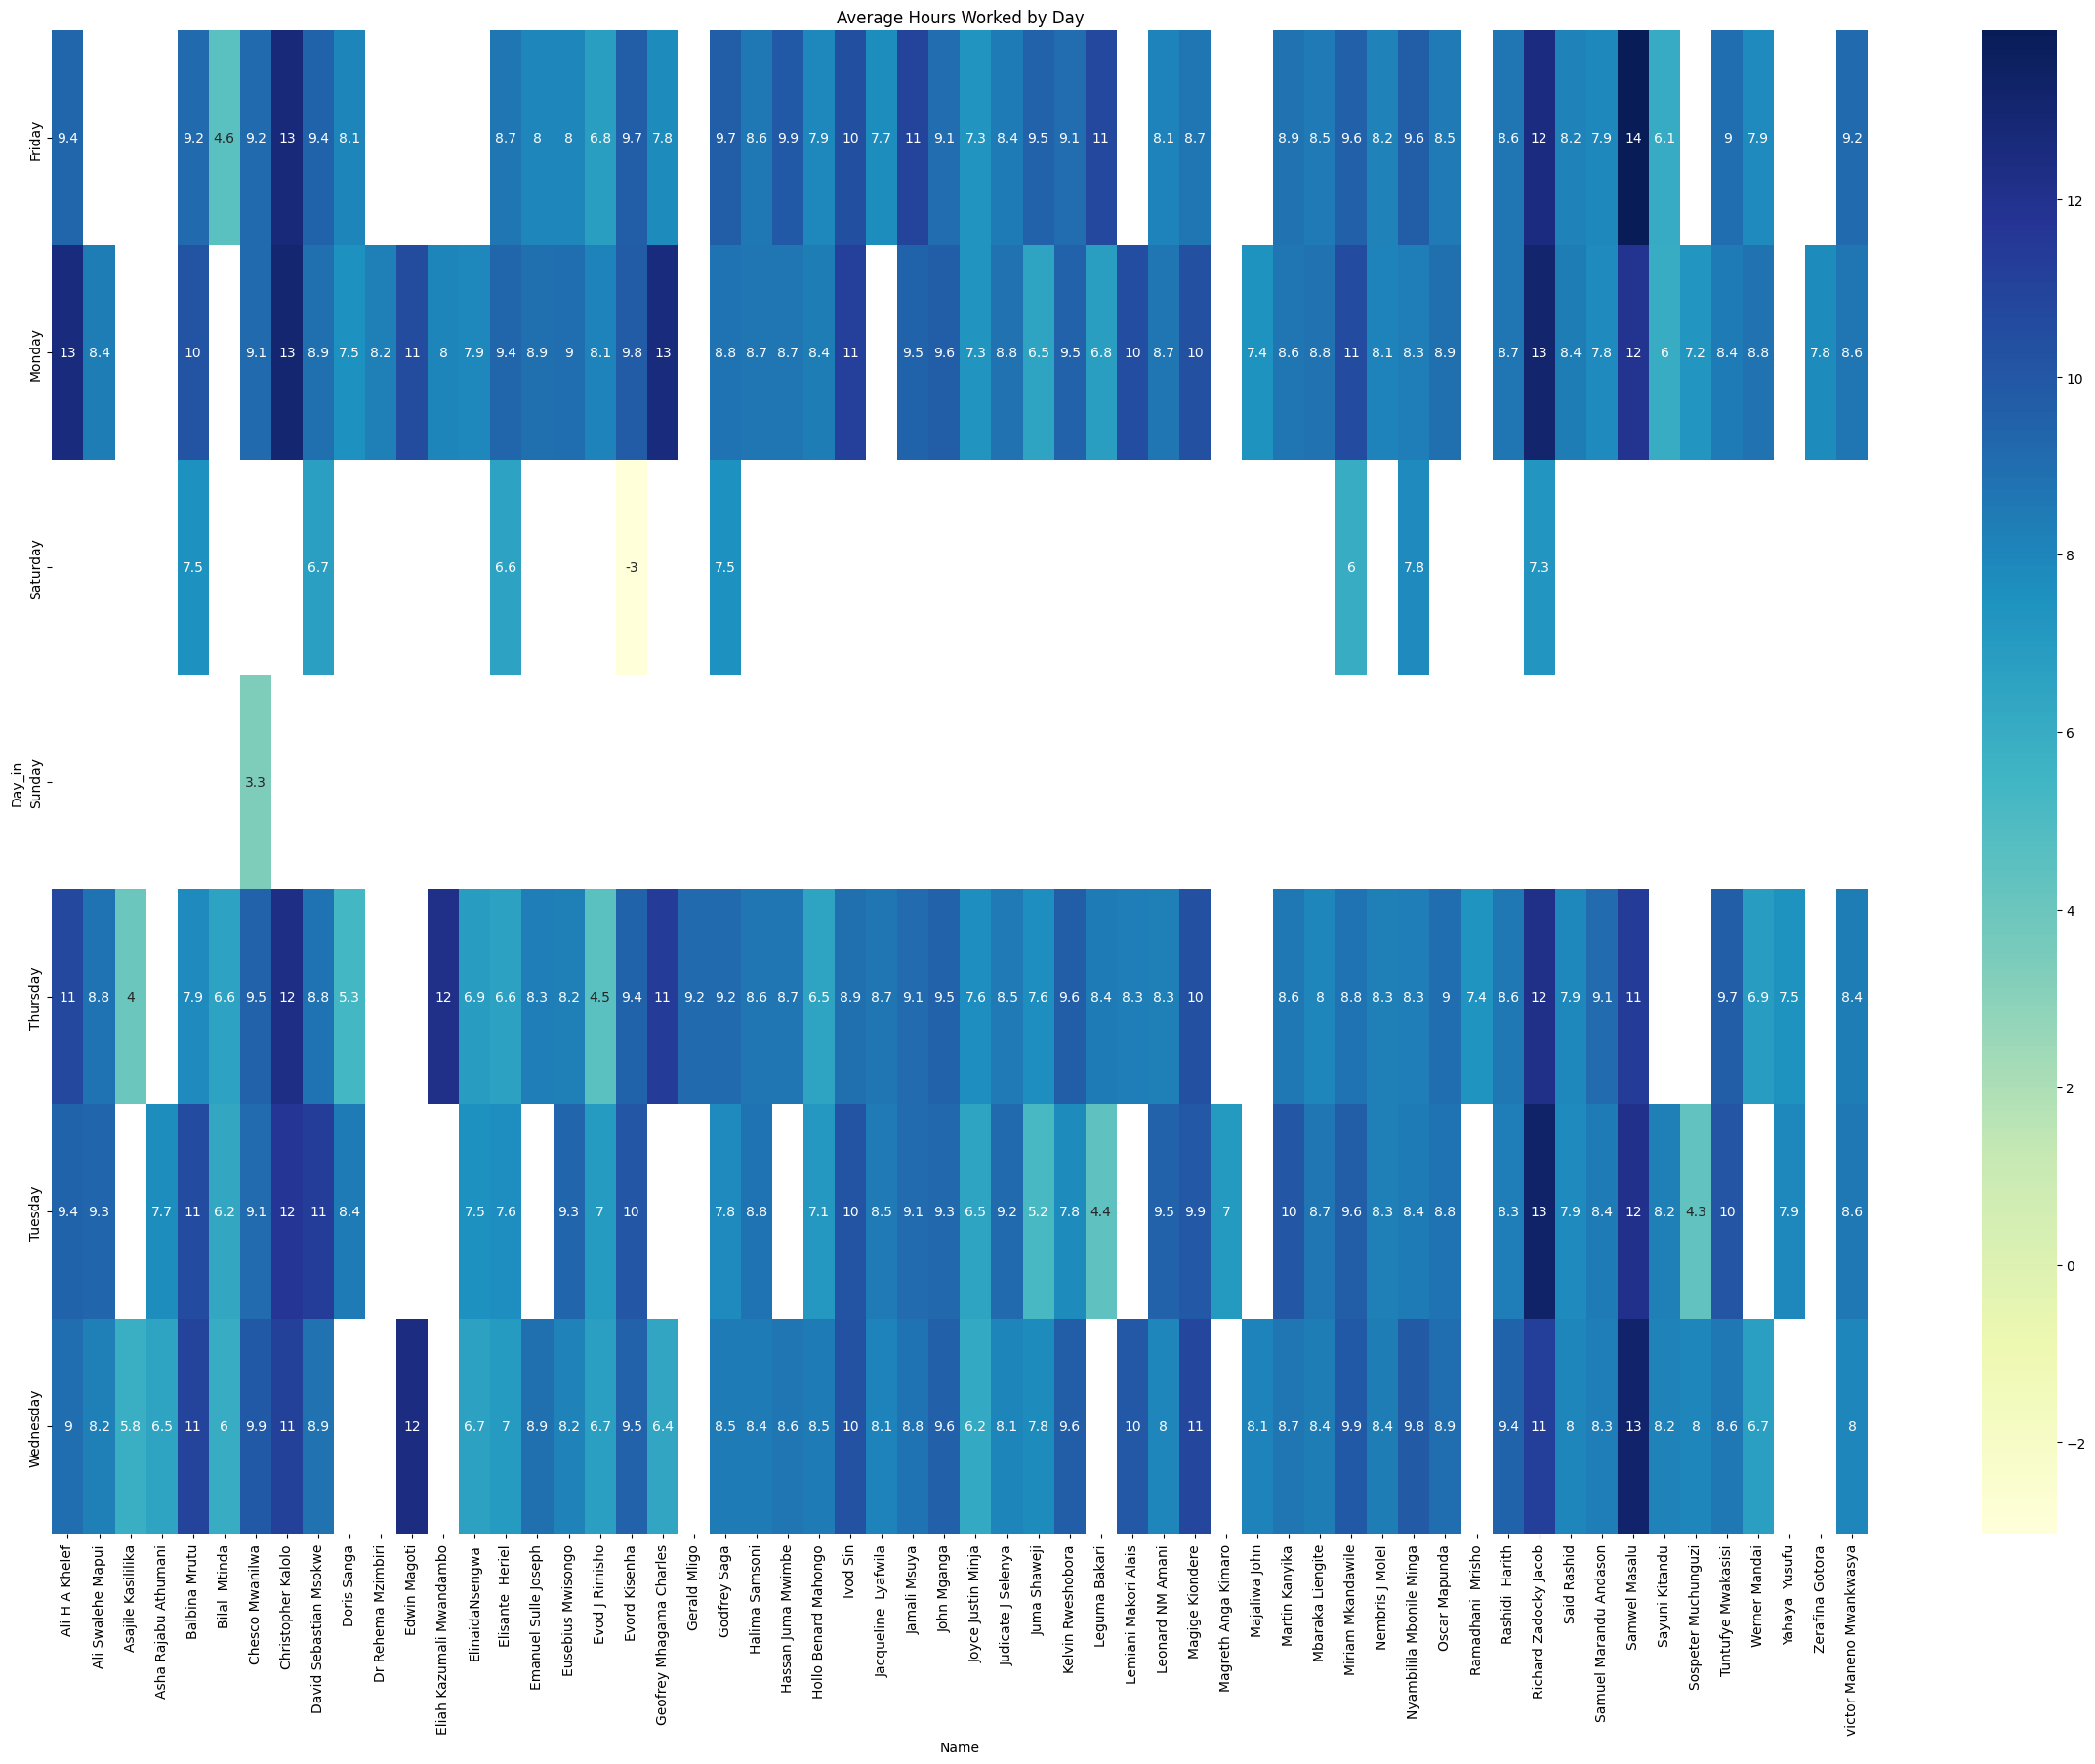

In [35]:
# Pivot data to see attendance patterns by day of the week
pivot_data = daily_data.pivot_table(values='Duration', index='Day_in', columns='Name', aggfunc='mean')
plt.figure(figsize=(30, 20))
sns.heatmap(pivot_data, annot=True, cmap="YlGnBu", cbar=True)
plt.title('Average Hours Worked by Day')
plt.show()


## Creating a word cloud for the most attended lecturer

In [56]:

# # !pip install wordcloud
# from wordcloud import WordCloud
# # Summing up Total_Hours by Name
# name_total_hours = weekly_hours.groupby('Name')['Total_Hours'].sum().to_dict()
# wordcloud = WordCloud(width=800, height=400, background_color='white',font_path="SF-Pro.ttf").generate_from_frequencies(name_total_hours)

# # Display the word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()
name_total_hours

#failed to create a word cloud due to ValueError: Only supported for TrueType fonts


{'Ali H A Khelef': 61.93333333333333,
 'Ali Swalehe Mapui': 60.63333333333334,
 'Asajile Kasililika': 9.85,
 'Asha Rajabu Athumani': 14.233333333333334,
 'Balbina Mrutu': 142.33333333333334,
 'Bilal  Mtinda': 30.016666666666666,
 'Chesco Mwanilwa': 189.98333333333335,
 'Christopher Kalolo': 208.93333333333334,
 'David Sebastian Msokwe': 126.0,
 'Doris Sanga': 81.41666666666666,
 'Dr Rehema Mzimbiri': 8.216666666666667,
 'Edwin Magoti': 22.96666666666667,
 'Eliah Kazumali Mwandambo': 36.21666666666667,
 'ElinaidaNsengwa': 36.550000000000004,
 'Elisante  Heriel': 145.15,
 'Emanuel Sulle Joseph': 77.2,
 'Eusebius Mwisongo': 145.01666666666668,
 'Evod J Rimisho': 75.03333333333333,
 'Evord Kisenha': 180.9,
 'Geofrey Mhagama Charles': 69.94999999999999,
 'Gerald Mligo': 9.183333333333334,
 'Godfrey Saga': 96.26666666666667,
 'Halima Samsoni': 77.65,
 'Hassan Juma Mwimbe': 35.849999999999994,
 'Hollo Benard Mahongo': 55.13333333333333,
 'Ivod Sin': 91.55,
 'Jacqueline  Lyafwila': 49.45,
 'Ja

## Machine Learning - Classification

In [57]:
# Define late arrival as checking in after 9 AM
daily_data['Late_Arrival'] = daily_data['Time_in'].apply(lambda x: 1 if x.hour > 9 else 0)


In [60]:
# Select features and target
X = daily_data[['Week', 'Duration']]  # Add more features if needed
y = daily_data['Late_Arrival']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       112
           1       0.56      0.56      0.56         9

    accuracy                           0.93       121
   macro avg       0.76      0.76      0.76       121
weighted avg       0.93      0.93      0.93       121

Accuracy: 0.9338842975206612


In [65]:
y

0      0
1      0
2      0
3      0
4      0
      ..
596    0
597    0
598    0
599    0
600    0
Name: Late_Arrival, Length: 601, dtype: int64

In [61]:
import pickle

# Save the model to a .pkl file using pickle
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print("Model saved as random_forest_model.pkl")

Model saved as random_forest_model.pkl


In [68]:
# Load the model from the .pkl file
with open('random_forest_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Make predictions using the loaded model
y_new_pred = loaded_model.predict(X_test)
print(f'Predictions: {y_new_pred}')


Predictions: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0]


## 0 being for late arrival and 1 for early arrival then the coclusions for the single model is there is a higher chance for late arrival this could help for future prediction 